In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

import re
import sys

/home/naradaw/miniconda3/envs/gnns/lib/python3.13/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Define paths
data_path = "/home/naradaw/code/GCNTFT/data/processed/data_w_geo_v3.csv"
embeddings_path = "/home/naradaw/code/GCNTFT/data/embeddings_v2_lap_202503312035/tft_ready_embeddings.csv"

# Load the air quality data
air_quality_df = pd.read_csv(data_path)
air_quality_df['datetime'] = pd.to_datetime(air_quality_df['datetime'])

# Load the embeddings
embeddings_df = pd.read_csv(embeddings_path, index_col=0)


In [4]:

# Convert the datetime to proper format for TimeSeriesDataSet
air_quality_df['time_idx'] = (air_quality_df['datetime'] - air_quality_df['datetime'].min()).dt.total_seconds() // 3600
air_quality_df['time_idx'] = air_quality_df['time_idx'].astype(int)
air_quality_df = air_quality_df.sort_values(['station_loc', 'time_idx'])


In [ ]:
air_quality_df['station_loc'] = air_quality_df['station_loc'].apply(lambda x: x.split(",")[0].strip())
# Display the unique station names
unique_stations = air_quality_df['station_loc'].unique()
print(f"Number of unique stations: {len(unique_stations)}")
print("Sample station names:")
print(unique_stations[:5])

# Use regex to detect and remove parentheses from station names
air_quality_df['station_loc'] = air_quality_df['station_loc'].apply(lambda x: re.sub(r'\([^)]*\)', '', x).strip())

# Check if any changes were made
print("\nAfter removing parentheses:")
print(air_quality_df['station_loc'].unique()[:5])

# Count unique station names after cleaning
print(f"Number of unique stations after cleaning: {len(air_quality_df['station_loc'].unique())}")

Number of unique stations: 37
Sample station names:
['Alipur' 'Anand Vihar' 'Ashok Vihar' 'Aya Nagar' 'Bawana']

After removing parentheses:
['Alipur' 'Anand Vihar' 'Ashok Vihar' 'Aya Nagar' 'Bawana']
Number of unique stations after cleaning: 37


In [ ]:
# Add a group_id column (required for pytorch-forecasting)
station_ids = air_quality_df['station_loc'].unique()
station_mapping = {station: idx for idx, station in enumerate(station_ids)}
air_quality_df['group_id'] = air_quality_df['station_loc'].map(station_mapping)

necessary_columns = ['datetime', 'time_idx', 'PM2.5 (ug/m3)', 'latitude', 'longitude', 'station_loc', 'group_id']
air_quality_df = air_quality_df[necessary_columns]
air_quality_df.rename(columns={'PM2.5 (ug/m3)': 'PM25'}, inplace=True)
# air_quality_df['station_loc'] = air_quality_df['station_loc'].astype('category')

In [7]:
air_quality_df.head()

,datetime,time_idx,PM25,latitude,longitude,station_loc,group_id
0,2022-03-31 23:00:00,0,122.0,28.797312,77.138667,Alipur,0
1,2022-04-01 00:00:00,1,85.0,28.797312,77.138667,Alipur,0
2,2022-04-01 01:00:00,2,85.0,28.797312,77.138667,Alipur,0
3,2022-04-01 02:00:00,3,81.0,28.797312,77.138667,Alipur,0
4,2022-04-01 03:00:00,4,68.0,28.797312,77.138667,Alipur,0


In [8]:
# Add time features
air_quality_df["hour"] = pd.to_datetime(air_quality_df["datetime"]).dt.hour
air_quality_df["day_of_week"] = pd.to_datetime(air_quality_df["datetime"]).dt.dayofweek
air_quality_df["month"] = pd.to_datetime(air_quality_df["datetime"]).dt.month

In [9]:
# Create station-specific features
for station in station_ids:
    # Create cyclical features with station-specific phase shifts
    station_data = air_quality_df[air_quality_df['station_loc'] == station]
    
    # Example: Add station-specific seasonal patterns
    # Find peak hour for each station 
    hourly_avg = station_data.groupby('hour')['PM25'].mean()
    peak_hour = hourly_avg.idxmax()
    
    # Create station-specific cyclic features with phase shift
    air_quality_df.loc[air_quality_df['station_loc'] == station, 'station_hour_sin'] = \
        np.sin(2 * np.pi * ((air_quality_df.loc[air_quality_df['station_loc'] == station, 'hour'] - peak_hour) % 24) / 24)
    air_quality_df.loc[air_quality_df['station_loc'] == station, 'station_hour_cos'] = \
        np.cos(2 * np.pi * ((air_quality_df.loc[air_quality_df['station_loc'] == station, 'hour'] - peak_hour) % 24) / 24)

In [10]:
# Add lag features before creating the dataset
for lag in [1, 3, 6, 12, 24]:
    air_quality_df[f'PM25_lag_{lag}'] = air_quality_df.groupby('station_loc')['PM25'].shift(lag)


In [11]:
# Add trend features
air_quality_df['PM25_diff_1'] = air_quality_df.groupby('station_loc')['PM25'].diff(1)
air_quality_df['PM25_diff_24'] = air_quality_df.groupby('station_loc')['PM25'].diff(24)

# Add rolling statistics
for window in [3, 6, 24]:
    air_quality_df[f'PM25_rolling_mean_{window}'] = air_quality_df.groupby('station_loc')['PM25'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean())

In [12]:
# Handle null values in the dataframe
# Check for null values in the dataframe
print("Null values in the dataframe before handling:")
null_counts = air_quality_df.isnull().sum()
print(null_counts[null_counts > 0])

# Calculate the percentage of missing values
print("\nPercentage of missing values:")
missing_percentage = air_quality_df.isnull().sum() / len(air_quality_df) * 100
print(missing_percentage[missing_percentage > 0].round(2))

Null values in the dataframe before handling:
PM25_lag_1       37
PM25_lag_3      111
PM25_lag_6      222
PM25_lag_12     444
PM25_lag_24     888
PM25_diff_1      37
PM25_diff_24    888
dtype: int64

Percentage of missing values:
PM25_lag_1      0.01
PM25_lag_3      0.03
PM25_lag_6      0.07
PM25_lag_12     0.14
PM25_lag_24     0.27
PM25_diff_1     0.01
PM25_diff_24    0.27
dtype: float64


In [13]:
air_quality_df.dropna(inplace=True)

Total number of stations: 37
Total number of observations: 323269
Average observations per station: 8737.0

Station with most data: Alipur (8737 rows)
Station with least data: Alipur (8737 rows)


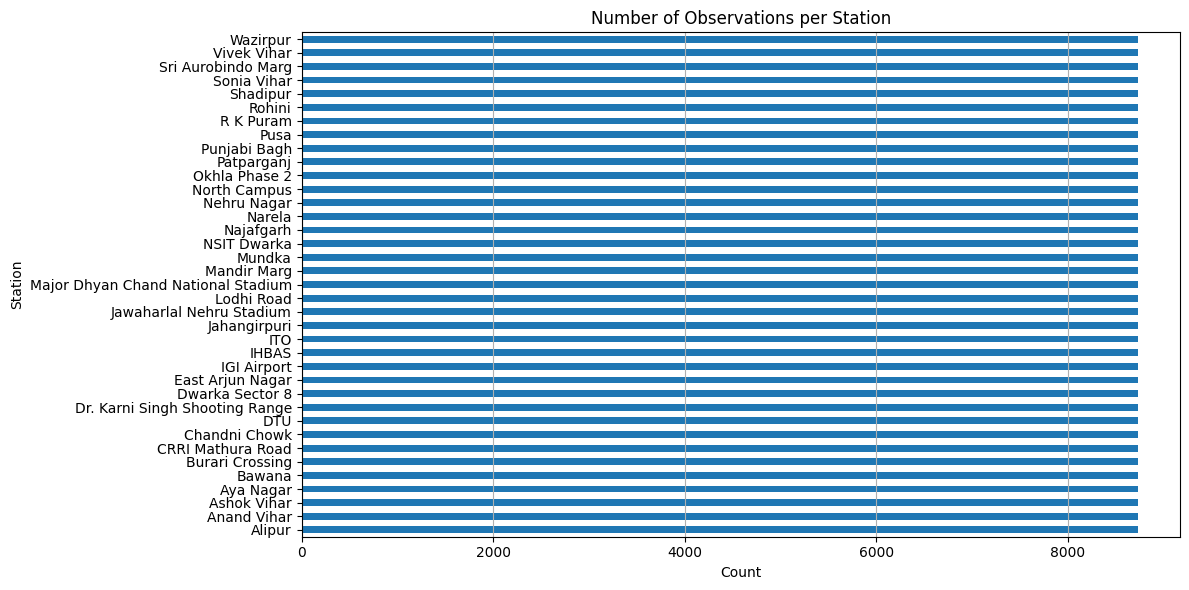

In [14]:
# Analyze the distribution of data across stations
station_counts = air_quality_df.groupby('station_loc').size()

# Display basic statistics
print(f"Total number of stations: {len(station_ids)}")
print(f"Total number of observations: {len(air_quality_df)}")
print(f"Average observations per station: {len(air_quality_df) / len(station_ids):.1f}")
print(f"\nStation with most data: {station_counts.idxmax()} ({station_counts.max()} rows)")
print(f"Station with least data: {station_counts.idxmin()} ({station_counts.min()} rows)")

# Visualize data distribution
plt.figure(figsize=(12, 6))
station_counts.sort_values().plot(kind='barh')
plt.title('Number of Observations per Station')
plt.xlabel('Count')
plt.ylabel('Station')
plt.tight_layout()
plt.grid(axis='x')

# Check for missing values in PM25 by station
pm25_missing = air_quality_df.groupby('station_loc')['PM25'].apply(lambda x: x.isna().sum())
if pm25_missing.sum() > 0:
    print(f"\nTotal missing PM25 values: {air_quality_df['PM25'].isna().sum()}")
    print("\nMissing PM25 values by station:")
    print(pm25_missing[pm25_missing > 0])

In [15]:
# Merge embeddings with the air quality data
# First, create a column for the embedding index
max_time_idx = air_quality_df['time_idx'].max()
window_size = 24  # assuming 24-hour window size used in GNN

# We need to match embeddings to the right time points
processed_data = []

for station in station_ids:
    station_data = air_quality_df[air_quality_df['station_loc'] == station]
    
    # For each time point with sufficient history
    for t in range(window_size, int(max_time_idx) + 1):
        if t in station_data['time_idx'].values:
            curr_data = station_data[station_data['time_idx'] == t].iloc[0].to_dict()
            
            # Find the embedding for this station at this time point
            station_idx = station_mapping[station]
            embedding_idx = (t - window_size) * len(station_ids) + station_idx
            
            if embedding_idx < len(embeddings_df):
                # Add embedding features
                for i in range(1, embeddings_df.shape[1]):
                    curr_data[f'embedding_{i}'] = embeddings_df.iloc[embedding_idx, i]
                
                processed_data.append(curr_data)

# Create new dataframe with embeddings
combined_df = pd.DataFrame(processed_data)

In [17]:
combined_df.to_csv("/home/naradaw/code/GCNTFT/data/processed/data_w_geo_v5_lap.csv", index=False)

In [16]:
sys.exit()

SystemExit: 

/home/naradaw/miniconda3/envs/gnns/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
from lightning.pytorch.loggers import MLFlowLogger

mlf_logger = MLFlowLogger(experiment_name="tft_only_forecasting", tracking_uri="file:./../mlflow_experiments")
# trainer = Trainer(logger=mlf_logger)

In [ ]:
# Define max_prediction_length and max_encoder_length
max_prediction_length = 24  # predict 24 hours ahead
max_encoder_length = 168  # use 7 days of history (168 hours) for making predictions

# Get unique station locations
unique_stations = air_quality_df["station_loc"].unique()

# Create a directory to store station-specific models
import os
os.makedirs("station_models", exist_ok=True)

# Training cutoff (same for all stations)
training_cutoff = air_quality_df["time_idx"].max() - max_prediction_length * 2

# Dictionary to store model performances
station_performances = {}

# Function to check for data quality issues
def check_data_quality(df, station_name):
    missing_values = df['PM25'].isna().sum()
    total_rows = len(df)
    percent_missing = (missing_values / total_rows) * 100
    
    print(f"Data quality for station {station_name}:")
    print(f"  - Total rows: {total_rows}")
    print(f"  - Missing PM25 values: {missing_values} ({percent_missing:.2f}%)")
    print(f"  - PM25 range: {df['PM25'].min():.2f} to {df['PM25'].max():.2f}, mean: {df['PM25'].mean():.2f}")
    
    if percent_missing > 10:
        print(f"  - WARNING: High percentage of missing values ({percent_missing:.2f}%)")
    
    return percent_missing

# Train separate models for each station
for station in unique_stations:
    print(f"\n{'='*50}")
    print(f"Training model for station: {station}")
    print(f"{'='*50}\n")
    
    # Filter data for this station
    station_df = air_quality_df[air_quality_df["station_loc"] == station].copy()
    
    # Check data quality
    missing_percent = check_data_quality(station_df, station)
    
    # Skip stations with excessive missing data
    if missing_percent > 30:
        print(f"Skipping station {station} due to excessive missing data")
        continue
    
    # Create the training dataset for this station
    training = TimeSeriesDataSet(
        data=station_df[station_df["time_idx"] <= training_cutoff],
        time_idx="time_idx",
        target="PM25",
        group_ids=["station_loc"],
        min_encoder_length=max_encoder_length // 2,  # allow for some missing data
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["station_loc"],
        static_reals=["latitude", "longitude"],
        time_varying_known_categoricals=[],
        time_varying_known_reals=["time_idx", "hour", "day_of_week", "month", "station_hour_sin", "station_hour_cos"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=["PM25", 
                                "PM25_lag_1", 
                                "PM25_lag_3", 
                                "PM25_lag_6", 
                                "PM25_lag_12", 
                                "PM25_lag_24",
                                "PM25_diff_1",
                                "PM25_diff_24",
                                "PM25_rolling_mean_3",
                                "PM25_rolling_mean_6", 
                                "PM25_rolling_mean_24"
                                ],
        # Changed normalization strategy from softplus to standard
        target_normalizer=GroupNormalizer(
            groups=["station_loc"]
        ),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    # Create the validation dataset for this station
    validation = TimeSeriesDataSet.from_dataset(
        training, 
        station_df, 
        min_prediction_idx=training_cutoff + 1
    )

    # Create data loaders with reduced batch size for small station datasets
    # Adjust batch size based on dataset size
    sample_count = len(station_df[station_df["time_idx"] <= training_cutoff])
    batch_size = min(32, max(8, sample_count // 20))  # Adaptive batch size
    
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4, shuffle=True)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 2, num_workers=4)

    # Define TFT model with adjusted parameters
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.0005,  # Reduced learning rate
        hidden_size=160,        # Increased hidden size
        attention_head_size=4,  # Reduced attention heads to prevent overfitting
        dropout=0.3,           # Increased dropout for regularization
        hidden_continuous_size=80,  # Increased hidden continuous size
        optimizer="ranger",     # Using Ranger optimizer (combines RAdam + LookAhead)
        loss=QuantileLoss(),
        reduce_on_plateau_patience=4,
    )

    # Create a station-specific logger
    mlf_logger_station = pl.loggers.MLFlowLogger(
        experiment_name=f"air_quality_prediction_{station}",
        tracking_uri="file:./ml-runs",
    )

    # Create PyTorch Lightning trainer with improved callbacks
    early_stop_callback = EarlyStopping(
        monitor="val_loss", 
        min_delta=1e-4, 
        patience=15,  # Increased patience
        verbose=True, 
        mode="min"
    )
    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    # Add ReduceLROnPlateau callback
    lr_callback = pl.callbacks.LearningRateMonitor(logging_interval="epoch")
    
    trainer = pl.Trainer(
        max_epochs=150,  # Increased max epochs
        accelerator="gpu",
        devices=1,
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback, lr_monitor, lr_callback],
        logger=mlf_logger_station,
        log_every_n_steps=10
    )

    # Train the model
    trainer.fit(
        tft, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=val_dataloader,
    )

    # Save the trained model with station name
    model_path = f"station_models/air_quality_tft_model_{station}.ckpt"
    trainer.save_checkpoint(model_path)
    
    print(f"\nModel for station {station} saved at: {model_path}")
    print(f"Best validation loss: {station_performances[station]}")
    
    # Optional: Perform prediction on validation set and visualize results?
    

# Print summary of model performance by station
print("\n\nModel Performance Summary:")
print("--------------------------")
for station, loss in sorted(station_performances.items(), key=lambda x: x[1]):
    print(f"Station {station}: Val Loss = {loss:.4f}")

/home/naradaw/miniconda3/envs/gnns/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/naradaw/miniconda3/envs/gnns/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



Training model for station: Alipur

Data quality for station Alipur:
  - Total rows: 8737
  - Missing PM25 values: 0 (0.00%)
  - PM25 range: 1.00 to 835.75, mean: 102.97


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 3.7 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 202 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 747 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 284 K  | train
7  | static_cont

Epoch 0: 100%|██████████| 272/272 [01:51<00:00,  2.44it/s, v_num=6a51, train_loss_step=30.40, val_loss=24.30, train_loss_epoch=41.10]

Metric val_loss improved. New best score: 24.273


Epoch 1: 100%|██████████| 272/272 [01:48<00:00,  2.50it/s, v_num=6a51, train_loss_step=38.50, val_loss=22.90, train_loss_epoch=27.30]

Metric val_loss improved by 1.385 >= min_delta = 0.0001. New best score: 22.888


Epoch 15: 100%|██████████| 272/272 [01:47<00:00,  2.54it/s, v_num=6a51, train_loss_step=18.50, val_loss=20.70, train_loss_epoch=19.10]

Metric val_loss improved by 2.149 >= min_delta = 0.0001. New best score: 20.740


Epoch 30: 100%|██████████| 272/272 [01:45<00:00,  2.58it/s, v_num=6a51, train_loss_step=18.70, val_loss=23.00, train_loss_epoch=17.10]

Monitored metric val_loss did not improve in the last 15 records. Best score: 20.740. Signaling Trainer to stop.


Epoch 30: 100%|██████████| 272/272 [01:46<00:00,  2.56it/s, v_num=6a51, train_loss_step=18.70, val_loss=23.00, train_loss_epoch=17.10]

Feature Importance Analysis:


AttributeError: 'TemporalFusionTransformer' object has no attribute 'interpret'

In [ ]:
import sys 
sys.exit()

SystemExit: 

/home/naradaw/miniconda3/envs/gnns/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
last_data = air_quality_df.groupby('station_loc').apply(lambda x: x.iloc[-max_encoder_length:]).reset_index(drop=True)

/tmp/ipykernel_1505/3576059663.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_data = air_quality_df.groupby('station_loc').apply(lambda x: x.iloc[-max_encoder_length:]).reset_index(drop=True)


In [ ]:
pred_dataset = TimeSeriesDataSet(
    data=last_data,
    time_idx="time_idx",
    target="PM25",
    group_ids=["station_loc"],
    min_encoder_length=max_encoder_length // 2,  # allow for some missing data
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["station_loc"],
    static_reals=["latitude", "longitude"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx", "hour", "day_of_week", "month", "station_hour_sin", "station_hour_cos"], #"time_idx"
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["PM25", 
                                "PM25_lag_1", 
                                "PM25_lag_3", 
                                "PM25_lag_6", 
                                "PM25_lag_12", 
                                "PM25_lag_24",
                                "PM25_diff_1",
                                "PM25_diff_24",
                                "PM25_rolling_mean_3",
                                "PM25_rolling_mean_6", 
                                "PM25_rolling_mean_24"
                                ],
    target_normalizer=GroupNormalizer(
        groups=["station_loc"], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


In [ ]:
predictions = tft.predict(pred_dataset)
predictions.shape

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/naradaw/miniconda3/envs/gnns/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


In [ ]:
# Check prediction variation across stations
print(f"Predictions shape: {predictions.shape}")
print("Prediction samples for first 5 timestamps:")
for i, station in enumerate(list(station_ids)[:5]):
    station_idx = station_mapping[station]
    print(f"Station {station}: {predictions[station_idx][:5].detach().cpu().numpy()}")

Predictions shape: torch.Size([6179, 24])
Prediction samples for first 5 timestamps:
Station Alipur: [24.984472 25.007977 25.178965 25.487686 25.921286]
Station Anand Vihar: [24.984472 25.007977 25.178965 25.487686 25.921286]
Station Ashok Vihar: [24.984472 25.007977 25.178965 25.487686 25.921286]
Station Aya Nagar: [24.984472 25.007977 25.178965 25.487686 25.921286]
Station Bawana: [24.984472 25.007977 25.178965 25.487686 25.921286]


In [ ]:
# Create separate prediction datasets for each station
all_predictions = []
station_preds_dict = {}

for station in station_ids:
    # Filter last data for just this station
    station_last_data = last_data[last_data['station_loc'] == station].reset_index(drop=True)
    
    # Create a station-specific prediction dataset
    station_pred_dataset = TimeSeriesDataSet(
        data=station_last_data,
        time_idx="time_idx",
        target="PM25",
        group_ids=["station_loc"],
        min_encoder_length=max_encoder_length // 2,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["station_loc"],
        static_reals=["latitude", "longitude"],
        time_varying_known_categoricals=[],
        time_varying_known_reals=["time_idx", "hour", "day_of_week", "month"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=["PM25"],
        target_normalizer=GroupNormalizer(
            groups=["station_loc"], transformation="log1p"
        ),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    
    # Create dataloader
    pred_dataloader = station_pred_dataset.to_dataloader(batch_size=1, train=False, shuffle=False)
    
    # Generate prediction for this station
    station_prediction = tft.predict(pred_dataloader)
    station_preds_dict[station] = station_prediction[0].detach().cpu().numpy()
    print(f"Station {station} prediction mean: {station_prediction[0].mean().item():.4f}")

In [ ]:
# Set up output directory
output_loc = f"/home/naradaw/code/GCNTFT/outputs/images_tft_only/{pd.Timestamp.now().strftime('%m%d%H%M')}_station_specific"

if not os.path.exists(output_loc):
    os.makedirs(output_loc)

# Plot predictions for each station using station-specific predictions
for station in station_ids:
    # Get the prediction for this station
    station_pred = station_preds_dict[station]
    
    plt.figure(figsize=(10, 6))
    
    # Plot the prediction
    plt.plot(range(max_prediction_length), station_pred, label='Prediction', color='blue')
    
    # Get historical data for comparison
    historical = air_quality_df[air_quality_df['station_loc'] == station].tail(max_encoder_length)['PM25'].values
    plt.plot(range(-len(historical), 0), historical, label='Historical', color='green')
    
    # Check if we have actual future data for this station
    station_data = air_quality_df[air_quality_df['station_loc'] == station]
    last_historical_idx = station_data[station_data['time_idx'] <= station_data['time_idx'].max() - max_prediction_length].tail(1)['time_idx'].item()
    
    # Get actual values for the prediction period if they exist in the dataset
    future_indices = range(last_historical_idx + 1, last_historical_idx + max_prediction_length + 1)
    future_data = station_data[station_data['time_idx'].isin(future_indices)]['PM25'].values
    
    # Plot actual future values if available
    if len(future_data) > 0:
        plt.plot(range(min(len(future_data), max_prediction_length)), future_data[:max_prediction_length], 
                 label='Actual', color='red', linestyle='-')
    
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.title(f'24-Hour Air Quality Forecast for Station {station}')
    plt.xlabel('Hours')
    plt.ylabel('PM25')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig(os.path.join(output_loc, f'station_{station}_forecast.png'))
    plt.close()

# Plot summary comparison of all station predictions
plt.figure(figsize=(12, 8))
for station in station_ids:
    plt.plot(range(max_prediction_length), station_preds_dict[station], label=f'Station {station}')

plt.title('Comparison of Predictions Across All Stations')
plt.xlabel('Hours')
plt.ylabel('PM25')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_loc, 'all_stations_comparison.png'))
plt.close()

# Print prediction statistics
print("\nPrediction statistics:")
for station in station_ids:
    pred = station_preds_dict[station]
    print(f"Station {station}: Min={pred.min():.2f}, Max={pred.max():.2f}, Mean={pred.mean():.2f}, Std={pred.std():.2f}")

print(f"\nForecasting completed. Plots saved to {output_loc}")


Prediction statistics:
Station Alipur: Min=22.96, Max=28.34, Mean=25.76, Std=1.64
Station Anand Vihar: Min=34.68, Max=42.24, Mean=38.63, Std=2.31
Station Ashok Vihar: Min=19.51, Max=24.17, Mean=21.94, Std=1.42
Station Aya Nagar: Min=17.14, Max=21.40, Mean=19.36, Std=1.30
Station Bawana: Min=27.59, Max=33.81, Mean=30.84, Std=1.90
Station Burari Crossing: Min=21.40, Max=26.53, Mean=24.07, Std=1.57
Station CRRI Mathura Road: Min=16.81, Max=21.78, Mean=19.38, Std=1.52
Station Chandni Chowk: Min=28.03, Max=32.12, Mean=30.19, Std=1.25
Station DTU: Min=26.66, Max=29.79, Mean=28.31, Std=0.95
Station Dr. Karni Singh Shooting Range: Min=24.09, Max=28.86, Mean=26.59, Std=1.45
Station Dwarka Sector 8: Min=24.94, Max=30.46, Mean=27.82, Std=1.68
Station East Arjun Nagar: Min=27.97, Max=27.98, Mean=27.98, Std=0.00
Station IGI Airport: Min=23.89, Max=28.66, Mean=26.39, Std=1.46
Station IHBAS: Min=26.23, Max=30.93, Mean=28.69, Std=1.43
Station ITO: Min=26.69, Max=31.64, Mean=29.28, Std=1.51
Station Ja

In [ ]:
# Check variable importance
raw_predictions, x = tft.predict(val_dataloader, return_x=True)


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ValueError: too many values to unpack (expected 2)

In [ ]:

# Generate interpretation
interpretation = tft.interpret_prediction(x, reduction="mean")

# Plot variable importance
plt.figure(figsize=(10, 8))
order = interpretation["static_variables"].mean(axis=0).argsort()
plt.barh(
    np.array(interpretation["static_variable_names"])[order],
    interpretation["static_variables"].mean(axis=0)[order]
)
plt.title("Static Variable Importance")
plt.tight_layout()
plt.savefig(os.path.join(output_loc, "static_variable_importance.png"))

AttributeError: 'TemporalFusionTransformer' object has no attribute 'interpret_prediction'

In [ ]:
station = station_ids[5]
station

'Burari Crossing'

In [ ]:
station_idx = station_mapping[station]
station_idx

5

In [ ]:
station_preds = predictions[station_idx].detach().cpu().numpy()
station_preds

array([24.984472, 25.007977, 25.178965, 25.487686, 25.921286, 26.458723,
       27.062433, 27.662863, 28.14237 , 28.3374  , 28.094805, 27.365152,
       26.261204, 25.020758, 23.92476 , 23.203539, 22.960508, 23.161558,
       23.692024, 24.422945, 25.249105, 26.096481, 26.921837, 27.700588],
      dtype=float32)

In [ ]:
last_timestamp = air_quality_df[air_quality_df['station_loc'] == station]['time_idx'].max()
last_timestamp

np.int64(8760)

In [ ]:
air_quality_df['station_loc']

0           Alipur
1           Alipur
2           Alipur
3           Alipur
4           Alipur
            ...   
324152    Wazirpur
324153    Wazirpur
324154    Wazirpur
324155    Wazirpur
324156    Wazirpur
Name: station_loc, Length: 324157, dtype: object

In [ ]:
air_quality_df[air_quality_df['station_loc'] == station]

,datetime,time_idx,PM25,latitude,longitude,station_loc,group_id,hour,day_of_week,month
43805,2022-03-31 23:00:00,0,107.52,28.728594,77.199325,Burari Crossing,5,23,3,3
43806,2022-04-01 00:00:00,1,81.85,28.728594,77.199325,Burari Crossing,5,0,4,4
43807,2022-04-01 01:00:00,2,60.89,28.728594,77.199325,Burari Crossing,5,1,4,4
43808,2022-04-01 02:00:00,3,71.02,28.728594,77.199325,Burari Crossing,5,2,4,4
43809,2022-04-01 03:00:00,4,67.48,28.728594,77.199325,Burari Crossing,5,3,4,4
...,...,...,...,...,...,...,...,...,...,...
52561,2023-03-31 19:00:00,8756,12.63,28.728594,77.199325,Burari Crossing,5,19,4,3
52562,2023-03-31 20:00:00,8757,28.63,28.728594,77.199325,Burari Crossing,5,20,4,3
52563,2023-03-31 21:00:00,8758,19.34,28.728594,77.199325,Burari Crossing,5,21,4,3
52564,2023-03-31 22:00:00,8759,25.36,28.728594,77.199325,Burari Crossing,5,22,4,3


In [ ]:
output_loc = f"/home/naradaw/code/GCNTFT/outputs/images_tft_only/{pd.Timestamp.now().strftime('%m%d%H%M')}"

if not os.path.exists(output_loc):
    os.makedirs(output_loc)

# Plot predictions for each station
for station in station_ids:
    station_idx = station_mapping[station]
    station_preds = predictions[station_idx].detach().cpu().numpy()
    
    # Get the future actual values for comparison if they exist
    last_timestamp = air_quality_df[air_quality_df['station_loc'] == station]['time_idx'].max()
    
    # Check if we have actual data for the prediction period
    station_data = air_quality_df[air_quality_df['station_loc'] == station]
    last_historical_idx = station_data.iloc[-1]['time_idx']
    
    # Get actual values for the prediction period if they exist in the dataset
    future_data = None
    if last_timestamp >= last_historical_idx + max_prediction_length:
        future_indices = range(last_historical_idx + 1, last_historical_idx + max_prediction_length + 1)
        future_data = station_data[station_data['time_idx'].isin(future_indices)]['PM25'].values
    plt.figure(figsize=(10, 6))
    plt.plot(range(max_prediction_length), station_preds, label='Prediction')
    
    # Get historical data for comparison
    historical = air_quality_df[air_quality_df['station_loc'] == station].tail(max_encoder_length)['PM25'].values
    plt.plot(range(-len(historical), 0), historical, label='Historical')
    
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.title(f'24-Hour Air Quality Forecast for Station {station}')
    plt.xlabel('Hours')
    plt.ylabel('PM25')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    
    plt.savefig(os.path.join(output_loc, f'station_{station}_forecast.png'))
    plt.close()

print("Forecasting completed. Plots saved to outputs/images/")

Forecasting completed. Plots saved to outputs/images/
